05NeuralNet

In [200]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile
import pickle

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [201]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

Import data and drop selected features

In [202]:
with open('data/train_valid_test_data.pickle', 'rb') as f:
    train_df, valid_df, test_df = pickle.load(f)

''' 
Drop features that have high percantage of missing values and 
have no noticable distribution differences.
'''

train_df.drop(train_df.columns[train_df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
valid_df.drop(valid_df.columns[valid_df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
test_df.drop(test_df.columns[test_df.columns.str.contains('unnamed',case = False)],   axis = 1, inplace = True)

drop_cols = ["FiO2", "Bilirubin_direct", "SBP", "DBP", "Hct", "HospAdmTime", "ICULOS"] 
train_df.drop(drop_cols, axis=1, inplace=True)
valid_df.drop(drop_cols, axis=1, inplace=True)
test_df.drop(drop_cols, axis=1, inplace=True)

Split features and labels

In [203]:
def split_features_and_labels(df):
    cols = df.columns
    return np.array(df[cols[:-1]].values), df[cols[-1]].values

In [204]:
X_train, y_train = split_features_and_labels(train_df)
X_valid, y_valid = split_features_and_labels(valid_df)
X_test, y_test   = split_features_and_labels(test_df)

Data Normalization and Scaling

In [205]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)
X_test  = scaler.transform(X_test)


X_train = np.clip(X_train, -5, 5)
X_valid = np.clip(X_valid, -5, 5)
X_test  = np.clip(X_test, -5, 5)

print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

pos_neg_train = len([1 for i in y_train if i == 1]) / len([1 for i in y_train if i == 0])
pos_neg_valid = len([1 for i in y_valid if i == 1]) / len([1 for i in y_valid if i == 0])
pos_neg_test  = len([1 for i in y_test if i == 1]) / len([1 for i in y_test if i == 0])

print(pos_neg_train)
print(pos_neg_valid)
print(pos_neg_test)

(552371, 30)
(119593, 30)
(118251, 30)
0.0222656105415109
0.021219728797349454
0.022658283678252372


Define the Neural Network architecture and metrics

In [206]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]


def make_model(metrics = METRICS, output_bias = None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)

  NUM_NEURONS = 500
  DROP_RATE   = 0.5 #50% chance of droping each neuron.
  model = keras.Sequential([
                            keras.layers.Dense(NUM_NEURONS, activation='relu', input_shape=(X_train.shape[-1],)),
                            keras.layers.Dropout(DROP_RATE),
                            keras.layers.Dense(NUM_NEURONS / 2, activation='relu'),
                            keras.layers.Dropout(DROP_RATE),
                            keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias),
                          ])

  model.compile(
                optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                loss=keras.losses.BinaryCrossentropy(),
                metrics=metrics
              )

  return model

''' 
Baseline model
'''

EPOCHS = 100
BATCH_SIZE = 256

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

model = make_model()
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_51 (Dense)            (None, 500)               15500     
                                                                 
 dropout_34 (Dropout)        (None, 500)               0         
                                                                 
 dense_52 (Dense)            (None, 250)               125250    
                                                                 
 dropout_35 (Dropout)        (None, 250)               0         
                                                                 
 dense_53 (Dense)            (None, 1)                 251       
                                                                 
Total params: 141,001
Trainable params: 141,001
Non-trainable params: 0
_________________________________________________________________


In [207]:
model.predict(X_train[:10])

array([[0.77757263],
       [0.77757263],
       [0.8006178 ],
       [0.78761435],
       [0.7688119 ],
       [0.76632273],
       [0.7692741 ],
       [0.7652021 ],
       [0.7777636 ],
       [0.77135444]], dtype=float32)

Set the custom initial bias value 

In [208]:
results = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

initial_bias = np.log([pos_neg_test])
model = make_model(output_bias=initial_bias)
model.predict(X_train[:10])
results = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 1.4799
Loss: 0.1051


In [209]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

Comparing results: custom bias value vs zero bias

In [ ]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
                                X_train,
                                y_train,
                                batch_size=BATCH_SIZE,
                                epochs=20,
                                validation_data=(X_valid, y_valid), 
                                verbose=0
                            )

model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
                                X_train,
                                y_train,
                                batch_size=BATCH_SIZE,
                                epochs=20,
                                validation_data=(X_valid, y_valid), 
                                verbose=0
                                )


In [12]:
def plot_loss(history, label, n):
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

In [ ]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

Helper plotting functions

In [210]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(fp, tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.plot([0,1],[0,1])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

Train the baseline model

In [26]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
                            X_train,
                            y_train,
                            batch_size = int(BATCH_SIZE / 4),
                            epochs = EPOCHS,
                            callbacks=[early_stopping],
                            validation_data=(X_valid, y_valid)
                            )


Epoch 1/100
8631/8631 [==============================] - 19s 2ms/step - loss: 0.0964 - tp: 127.0000 - fp: 159.0000 - tn: 655812.0000 - fn: 14524.0000 - accuracy: 0.9781 - precision: 0.4441 - recall: 0.0087 - auc: 0.7417 - prc: 0.0773 - val_loss: 0.0920 - val_tp: 35.0000 - val_fp: 14.0000 - val_tn: 117094.0000 - val_fn: 2450.0000 - val_accuracy: 0.9794 - val_precision: 0.7143 - val_recall: 0.0141 - val_auc: 0.7463 - val_prc: 0.0799
Epoch 2/100
8631/8631 [==============================] - 17s 2ms/step - loss: 0.0931 - tp: 211.0000 - fp: 225.0000 - tn: 540115.0000 - fn: 11820.0000 - accuracy: 0.9782 - precision: 0.4839 - recall: 0.0175 - auc: 0.7728 - prc: 0.1038 - val_loss: 0.0920 - val_tp: 49.0000 - val_fp: 20.0000 - val_tn: 117088.0000 - val_fn: 2436.0000 - val_accuracy: 0.9795 - val_precision: 0.7101 - val_recall: 0.0197 - val_auc: 0.7453 - val_prc: 0.0835
Epoch 3/100
8631/8631 [==============================] - 19s 2ms/step - loss: 0.0915 - tp: 335.0000 - fp: 267.0000 - tn: 540073.00

Evaluate the base model performance

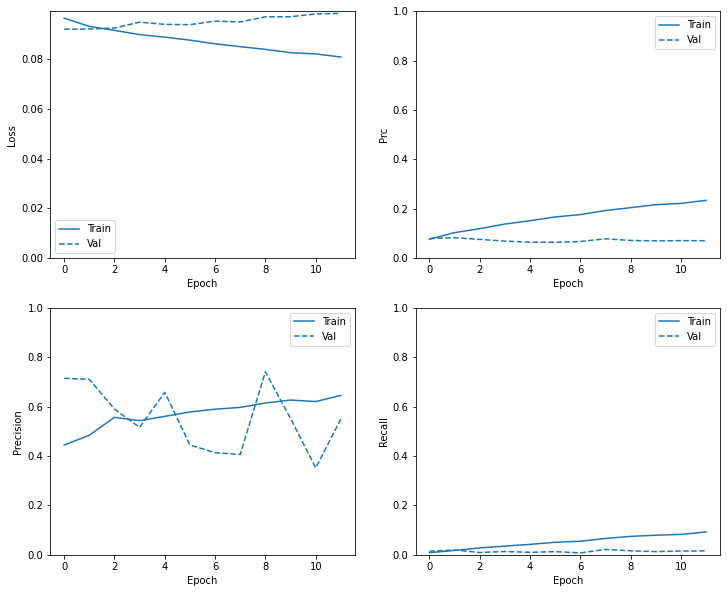

In [27]:
plot_metrics(baseline_history)

In [39]:
train_predictions_baseline = model.predict(X_train, batch_size=BATCH_SIZE) 
test_predictions_baseline = model.predict(X_test, batch_size=BATCH_SIZE) 

loss :  0.09572568535804749
tp :  31.0
fp :  10.0
tn :  115621.0
fn :  2589.0
accuracy :  0.9780213236808777
precision :  0.7560975551605225
recall :  0.011832061223685741
auc :  0.7609980702400208
prc :  0.0925351083278656



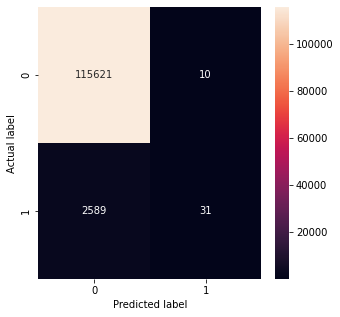

In [40]:
baseline_results = model.evaluate(X_test, y_test,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_baseline)


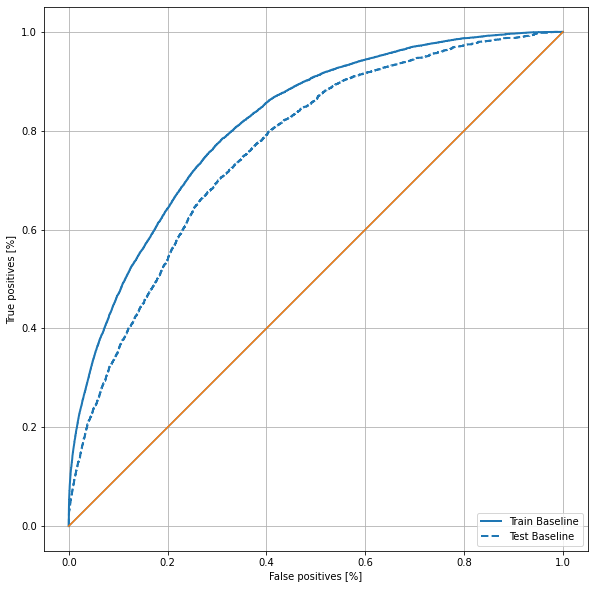

In [41]:
plot_roc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", y_test, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

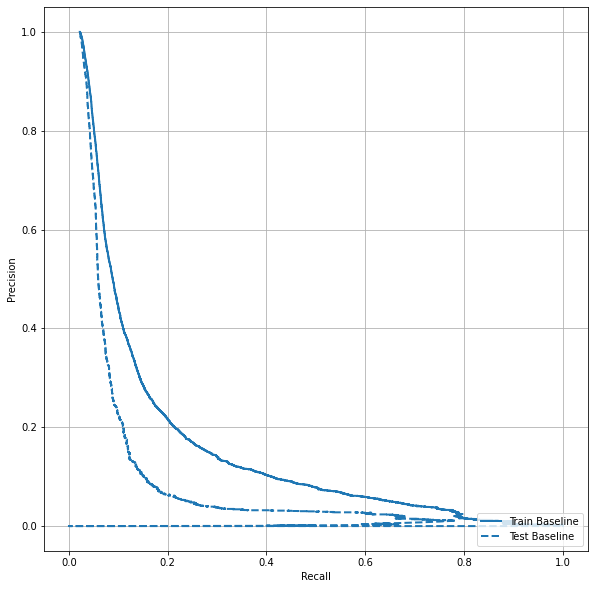

In [42]:
plot_prc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", y_test, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

Search for optimal batch size

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

BATCHES   = [i for i in range(32, 252, 20)]
EPOCHS    = [100]
CV = 3 
param_grid = dict(epochs = EPOCHS, batch_size = BATCHES)
grid = GridSearchCV(estimator = KerasClassifier(build_fn = make_model), 
                            param_grid = param_grid,
                            cv = CV,
                            verbose = True)
                            
grid_result = grid.fit(X_train, y_train)

In [ ]:
print(grid_result.best_params_)

Class Weights

In [211]:
'''
The goal is to identify septic patients, but we don't have very many of those positive samples to work with,
so we would want to have the classifier heavily weight the few examples that are available. This causes the model
to pay more attention to minorty class.
'''

total = len(y_train)
neg = len([ 1 for y in y_train if y == 0])
pos = len([ 1 for y in y_train if y == 1])
print(pos / total)

weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for sepsis negative class: {:.2f}'.format(weight_for_0))
print('Weight for sepsis positve class: {:.2f}'.format(weight_for_1))

0.021780651047936986
Weight for sepsis negative class: 0.51
Weight for sepsis positve class: 22.96


Train Weighted Model

In [58]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    X_train,
    y_train,
    batch_size = int(BATCH_SIZE / 5),
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(X_valid, y_valid),
    class_weight=class_weight)

Epoch 1/100
10831/10831 [==============================] - 23s 2ms/step - loss: 0.6464 - tp: 8424.0000 - fp: 167844.0000 - tn: 488127.0000 - fn: 6227.0000 - accuracy: 0.7404 - precision: 0.0478 - recall: 0.5750 - auc: 0.7237 - prc: 0.0578 - val_loss: 0.4414 - val_tp: 1224.0000 - val_fp: 21477.0000 - val_tn: 95631.0000 - val_fn: 1261.0000 - val_accuracy: 0.8099 - val_precision: 0.0539 - val_recall: 0.4926 - val_auc: 0.7452 - val_prc: 0.0640
Epoch 2/100
10831/10831 [==============================] - 24s 2ms/step - loss: 0.5934 - tp: 7727.0000 - fp: 140711.0000 - tn: 399629.0000 - fn: 4304.0000 - accuracy: 0.7375 - precision: 0.0521 - recall: 0.6423 - auc: 0.7634 - prc: 0.0727 - val_loss: 0.5180 - val_tp: 1499.0000 - val_fp: 27063.0000 - val_tn: 90045.0000 - val_fn: 986.0000 - val_accuracy: 0.7655 - val_precision: 0.0525 - val_recall: 0.6032 - val_auc: 0.7572 - val_prc: 0.0716
Epoch 3/100
10831/10831 [==============================] - 21s 2ms/step - loss: 0.5644 - tp: 8156.0000 - fp: 1311

Evaluate weighted model performance

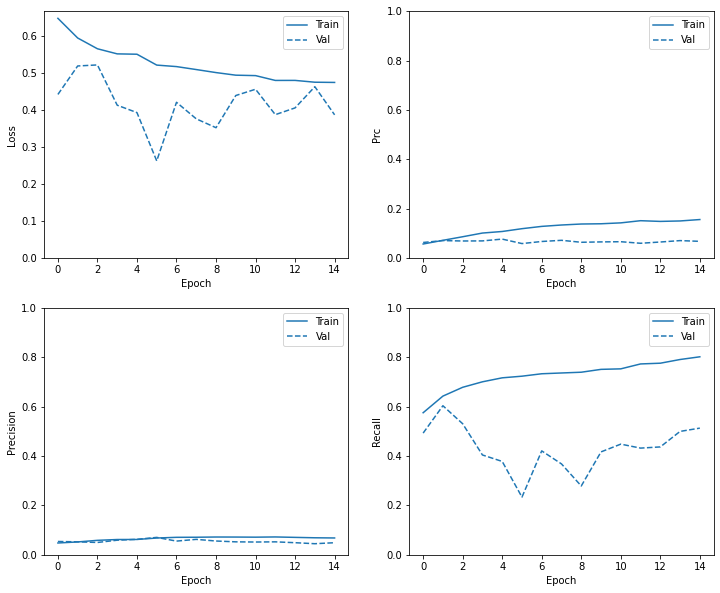

In [59]:
plot_metrics(weighted_history)

In [60]:
train_predictions_weighted = weighted_model.predict(X_train, batch_size=BATCH_SIZE) 
test_predictions_weighted  = weighted_model.predict(X_test, batch_size=BATCH_SIZE)

loss :  0.3834412395954132
tp :  921.0
fp :  12623.0
tn :  103008.0
fn :  1699.0
accuracy :  0.8788847327232361
precision :  0.06800059229135513
recall :  0.3515267074108124
auc :  0.7507770657539368
prc :  0.07772089540958405



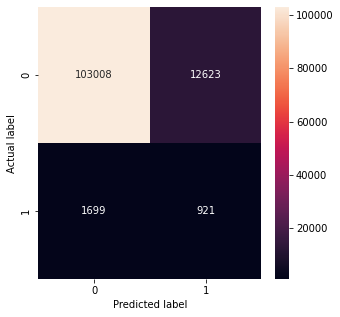

In [61]:
weighted_results = weighted_model.evaluate(X_test, y_test,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_weighted)


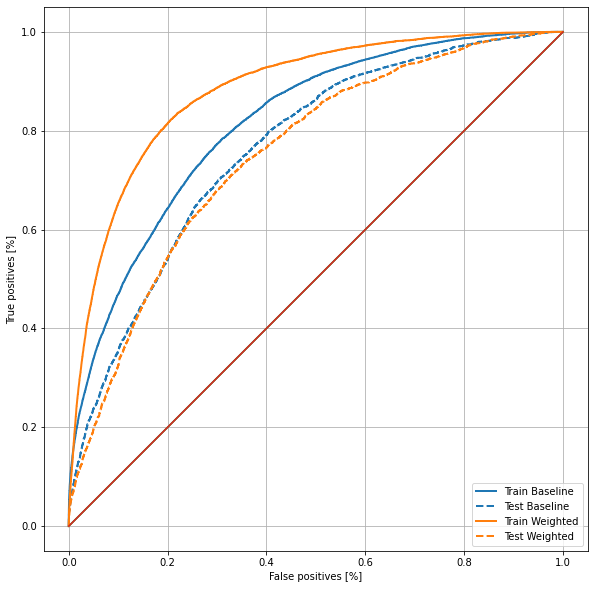

In [62]:
'''
Here you can see that with class weights the accuracy and precision are lower because there are more false positives, 
but conversely the recall and AUC are higher because the model also found more true positives. 
Despite having lower accuracy, this model has higher recall (and identifies more fraudulent transactions). 
Of course, there is a cost to both types of error (you wouldn't want to bug users by flagging too many legitimate transactions as fraudulent, either). 
Carefully consider the trade-offs between these different types of errors for your application.
'''

plot_roc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline",  y_test, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", y_train, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", y_test, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right')

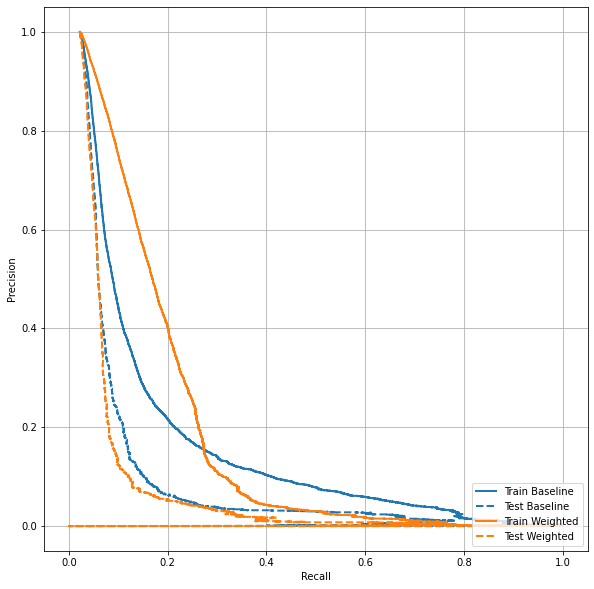

In [63]:
plot_prc("Train Baseline", y_train,  train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline",  y_test, test_predictions_baseline, color=colors[0], linestyle='--')

plot_prc("Train Weighted", y_train, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted",  y_test, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right')

Train Weighed NeuralNet using Feature Selection

In [212]:
with open('data/train_valid_test_data.pickle', 'rb') as f:
    train_df, valid_df, test_df = pickle.load(f)

''' 
Drop features that have high percantage of missing values and 
have no noticable distribution differences.
'''

train_df.drop(train_df.columns[train_df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
valid_df.drop(valid_df.columns[valid_df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
test_df.drop(test_df.columns[test_df.columns.str.contains('unnamed',case = False)],   axis = 1, inplace = True)

drop_cols = ["FiO2", "Bilirubin_direct", "SBP", "DBP", "Hct", "HospAdmTime", "ICULOS"] 
train_df.drop(drop_cols, axis=1, inplace=True)
valid_df.drop(drop_cols, axis=1, inplace=True)
test_df.drop(drop_cols, axis=1, inplace=True)

Pick features selected by Random Forest

In [213]:
rf_features = ['HR', 'Temp', 'MAP', 'Resp', 'PaCO2', 'BUN', 'Chloride', 'Creatinine', 'Glucose', 'Potassium', 'Hgb', 'PTT', 'WBC', 'Platelets', 'Age', 'SepsisLabel']
train_df= train_df[rf_features]
valid_df = valid_df[rf_features]
test_df  = test_df[rf_features]

In [214]:
print(train_df.shape)
print(valid_df.shape)
print(test_df.shape)

(552371, 16)
(119593, 16)
(118251, 16)


In [215]:
X_train, y_train = split_features_and_labels(train_df)
X_valid, y_valid = split_features_and_labels(valid_df)
X_test, y_test   = split_features_and_labels(test_df)

In [216]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)
X_test  = scaler.transform(X_test)


X_train = np.clip(X_train, -5, 5)
X_valid = np.clip(X_valid, -5, 5)
X_test  = np.clip(X_test, -5, 5)


print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

pos_neg_train = len([1 for i in y_train if i == 1]) / len([1 for i in y_train if i == 0])
pos_neg_valid = len([1 for i in y_valid if i == 1]) / len([1 for i in y_valid if i == 0])
pos_neg_test  = len([1 for i in y_test if i == 1]) / len([1 for i in y_test if i == 0])

print(pos_neg_train)
print(pos_neg_valid)
print(pos_neg_test)

(552371, 15)
(119593, 15)
(118251, 15)
0.0222656105415109
0.021219728797349454
0.022658283678252372


Train Model 

In [217]:
feature_sel_model = make_model()

feature_sel_history = feature_sel_model.fit(
                                X_train,
                                y_train,
                                batch_size= int(BATCH_SIZE / 4),
                                epochs=EPOCHS,
                                callbacks=[early_stopping],
                                validation_data=(X_valid, y_valid),
                                class_weight=class_weight)

Epoch 1/100
8631/8631 [==============================] - 21s 2ms/step - loss: 0.6270 - tp: 20809.0000 - fp: 773826.0000 - tn: 847194.0000 - fn: 15284.0000 - accuracy: 0.5238 - precision: 0.0262 - recall: 0.5765 - auc: 0.5420 - prc: 0.0322 - val_loss: 0.5564 - val_tp: 1609.0000 - val_fp: 38637.0000 - val_tn: 78471.0000 - val_fn: 876.0000 - val_accuracy: 0.6696 - val_precision: 0.0400 - val_recall: 0.6475 - val_auc: 0.7247 - val_prc: 0.0741
Epoch 2/100
8631/8631 [==============================] - 20s 2ms/step - loss: 0.6016 - tp: 8922.0000 - fp: 212319.0000 - tn: 328021.0000 - fn: 3109.0000 - accuracy: 0.6100 - precision: 0.0403 - recall: 0.7416 - auc: 0.7387 - prc: 0.0758 - val_loss: 0.5780 - val_tp: 1852.0000 - val_fp: 46407.0000 - val_tn: 70701.0000 - val_fn: 633.0000 - val_accuracy: 0.6067 - val_precision: 0.0384 - val_recall: 0.7453 - val_auc: 0.7383 - val_prc: 0.0815
Epoch 3/100
8631/8631 [==============================] - 19s 2ms/step - loss: 0.5928 - tp: 9012.0000 - fp: 208971.00

Evaluate Model Perfomance

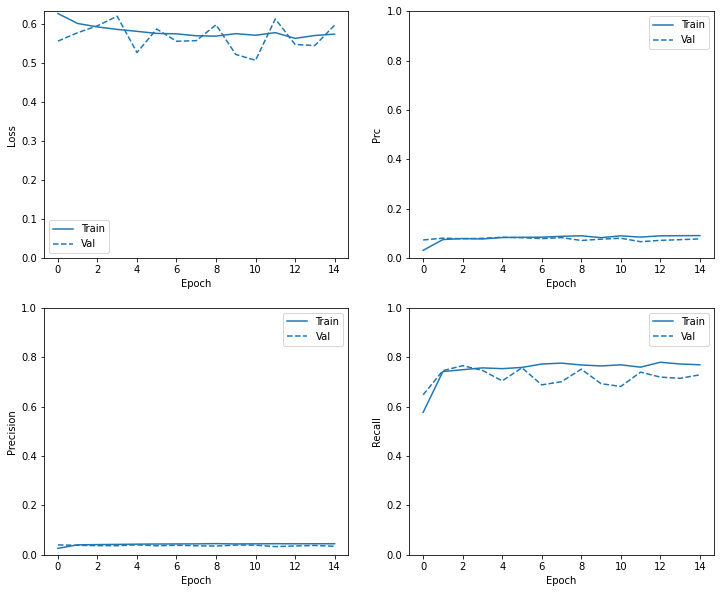

In [218]:
plot_metrics(feature_sel_history)

In [222]:
train_prediction_feature_sel = feature_sel_model.predict(X_train, batch_size = BATCH_SIZE) 
test_predictions_feature_sel = feature_sel_model.predict(X_test, batch_size = BATCH_SIZE)

loss :  0.5148546695709229
tp :  1912.0
fp :  39438.0
tn :  76193.0
fn :  708.0
accuracy :  0.6605018377304077
precision :  0.046239420771598816
recall :  0.7297710180282593
auc :  0.7593860626220703
prc :  0.07395583391189575



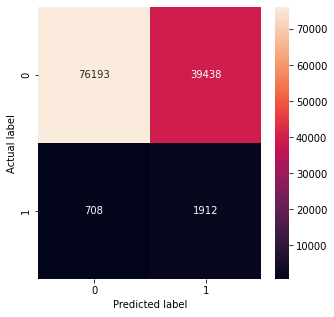

In [223]:
feature_sel_results = feature_sel_model.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=0)

for name, value in zip(feature_sel_model.metrics_names, feature_sel_results):
  print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_feature_sel)

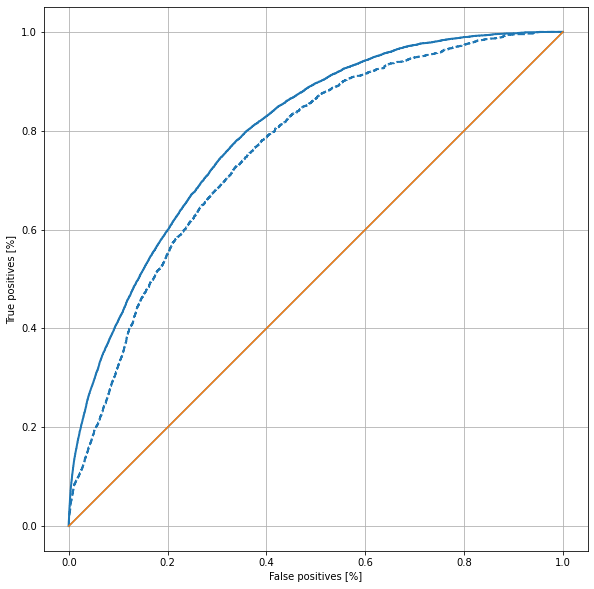

In [224]:
plot_roc("Train Feature Selection", y_train, train_prediction_feature_sel, color=colors[0])
plot_roc("Train Feature Selection", y_test, test_predictions_feature_sel, color=colors[0], linestyle='--')

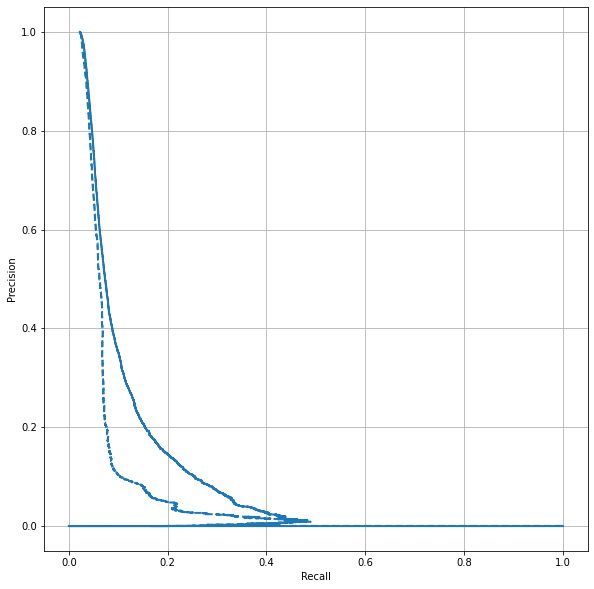

In [225]:
plot_prc("Train Feature Selection",  y_train, train_prediction_feature_sel, color=colors[0])
plot_prc("Train Feature Selection",  y_test, test_predictions_feature_sel, color=colors[0], linestyle='--')

ReliefF Feature Selection

In [183]:
'''
A set of features selected by relief algorithm.
'''
#selected_features = ['HR', 'Platelets', 'PTT', 'Glucose', 'HCO3', 'WBC', 'Hgb', 'Age', 'Resp', 'Potassium', 'MAP', 'BUN', 'Magnesium', 'Phosphate', 'BaseExcess', 'SepsisLabel']
selected_features = ['HR', 'Platelets', 'PTT', 'Glucose', 'HCO3', 'WBC', 'Hgb', 'Age', 'Resp', 'Potassium', 'MAP', 'BUN', 'Magnesium', 'Phosphate', 'BaseExcess', 'Lactate', 'O2Sat', 'Chloride', 'Creatinine', 'Alkalinephos', 'SepsisLabel']

In [186]:
'''
Keep only selected features from original dataframe
'''
train_df = train_df[selected_features]
valid_df = valid_df[selected_features]
test_df  = test_df[selected_features]

In [187]:
X_train, y_train = split_features_and_labels(train_df)
X_valid, y_valid = split_features_and_labels(valid_df)
X_test, y_test   = split_features_and_labels(test_df)

In [188]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)
X_test  = scaler.transform(X_test)


X_train = np.clip(X_train, -5, 5)
X_valid = np.clip(X_valid, -5, 5)
X_test  = np.clip(X_test, -5, 5)

Train model with selected features

In [195]:
relief_model = make_model()

relief_history = relief_model.fit(
                                X_train,
                                y_train,
                                batch_size= int(BATCH_SIZE / 4),
                                epochs=EPOCHS,
                                callbacks=[early_stopping],
                                validation_data=(X_valid, y_valid),
                                class_weight=class_weight
                                )

Epoch 1/100
8631/8631 [==============================] - 20s 2ms/step - loss: 0.6177 - tp: 9559.0000 - fp: 211280.0000 - tn: 444691.0000 - fn: 5092.0000 - accuracy: 0.6774 - precision: 0.0433 - recall: 0.6524 - auc: 0.7252 - prc: 0.0591 - val_loss: 0.5418 - val_tp: 1437.0000 - val_fp: 31342.0000 - val_tn: 85766.0000 - val_fn: 1048.0000 - val_accuracy: 0.7292 - val_precision: 0.0438 - val_recall: 0.5783 - val_auc: 0.7257 - val_prc: 0.0655
Epoch 2/100
8631/8631 [==============================] - 17s 2ms/step - loss: 0.5939 - tp: 8131.0000 - fp: 162911.0000 - tn: 377429.0000 - fn: 3900.0000 - accuracy: 0.6980 - precision: 0.0475 - recall: 0.6758 - auc: 0.7511 - prc: 0.0712 - val_loss: 0.5694 - val_tp: 1593.0000 - val_fp: 37330.0000 - val_tn: 79778.0000 - val_fn: 892.0000 - val_accuracy: 0.6804 - val_precision: 0.0409 - val_recall: 0.6410 - val_auc: 0.7296 - val_prc: 0.0663
Epoch 3/100
8631/8631 [==============================] - 17s 2ms/step - loss: 0.5796 - tp: 8464.0000 - fp: 166201.000

In [ ]:
plot_metrics(relief_history)

In [197]:
train_prediction_relief = relief_model.predict(X_train, batch_size = BATCH_SIZE)
test_predictions_relief = relief_model.predict(X_test, batch_size = BATCH_SIZE)

In [ ]:
relief_results = relief_model.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=0)

for name, value in zip(relief_model.metrics_names, relief_results):
  print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_relief)

In [ ]:
plot_roc("Train Feature Selection", y_train, train_prediction_relief, color=colors[0])
plot_roc("Train Feature Selection", y_test, test_predictions_relief, color=colors[0], linestyle='--')

In [ ]:
plot_prc("Train Feature Selection",  y_train, train_prediction_relief, color=colors[0])
plot_prc("Train Feature Selection",  y_test, test_predictions_relief, color=colors[0], linestyle='--')